In [52]:
# Libraries required for the analysis
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
from collections import Counter
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")
from spacy.lang.en import stop_words
nlp = spacy.load('en_core_web_sm')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
#Read Posts data
posts=pd.read_csv('edmunds_extraction_5000_posts.csv',names=['user','date','post'])
#drop duplicates post
posts.drop_duplicates(subset='post',inplace=True)
#convert to lower case
posts['post']=posts['post'].str.lower()
posts.head()

,user,date,post
0,merc1,March 2002,i personally think that with a few tweaks the...
1,fredvh,March 2002,i am debating a new purchase and these two ar...
2,blueguydotcom,March 2002,"great handling, rwd, excellent engine and the..."
3,hungrywhale,March 2002,and no manual tranny. that may not matter to ...
4,riez,March 2002,one beauty of bmw 3 series is that there are ...


In [18]:
posts.shape

(5181, 3)

In [19]:
#model data
models=pd.read_csv('models.csv',names=['brands','model'])
#convert lower case 
models['brands']=models['brands'].str.lower()
models['model']=models['model'].str.lower()
#delete row withh  brands is cars
models.drop(models[models['brands']=='car'].index,inplace=True)
unique_brands=models['brands'].unique()


In [20]:
# models where brands is cars
models['brands'].value_counts()

toyota        98
chevrolet     63
honda         46
hyundai       40
mazda         30
suzuki        29
ford          24
bmw           22
subaru        21
nissan        17
pontiac       17
volkswagen    14
dodge         12
infiniti      10
kia           10
audi          10
acura          9
chrysler       9
lincoln        8
buick          8
mercedes       7
volvo          7
cadillac       3
mitsubishi     2
mercury        2
nissan.        2
saturn         1
toyata         1
volkwagen      1
Name: brands, dtype: int64

In [21]:
from collections import defaultdict

models_dict = defaultdict(list)

for index, row in models.iterrows():
    models_dict[row['brands']].append(row['model'])
models_dict

defaultdict(list,
            {'acura': ['integra',
              'legend',
              'vigor',
              'rlx',
              'ilx',
              'mdx',
              'rdx',
              'tsx',
              'rsx'],
             'audi': ['quattro',
              'a4',
              'a6',
              'a5',
              'a7',
              'q3',
              'q5',
              'q7',
              'a8',
              'a3'],
             'bmw': ['3-series',
              '5-series',
              '6-series',
              '4-series',
              'xdrive',
              'alpina',
              '330ci',
              '328i',
              '330c',
              '335i',
              '335d',
              '528i',
              '535i',
              '128i',
              '640i',
              '3er',
              '5er',
              'm5',
              'm3',
              'm6',
              'bmws',
              'bmwesque'],
             'buick': ['park avenue',
             

In [22]:
# Function to replace models with brands
def replace_models(text, models_dict):
    for brand, models in models_dict.items():
        for model in models:
            pattern = r'\b' + re.escape(model) + r'\b'
            text = re.sub(pattern, brand, text)
    return text

# Function to clean text
def clean_text(x):
    x = x.lower()
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r"https?://[^\s]+", "", x)
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x)
    x = ' '.join([token.lemma_ for token in nlp(x)])  
    x = re.sub(r' +', ' ', x)
    x = x.strip()
    return x

# Then apply clean_text
posts['post'] = posts['post'].apply(clean_text)


# Apply replace_models first
posts['post'] = posts['post'].apply(lambda x: replace_models(x, models_dict))

# Display the head of the DataFrame
posts.head()


,user,date,post
0,merc1,March 2002,I personally think that with a few tweak the c...
1,fredvh,March 2002,I be debate a new purchase and these two be at...
2,blueguydotcom,March 2002,"great handling , rwd , excellent engine and th..."
3,hungrywhale,March 2002,and no manual tranny . that may not matter to ...
4,riez,March 2002,one beauty of bmw 3 series be that there be so...


In [23]:
#export to csv
posts.to_csv('posts_converted.csv',index=False)

In [24]:
# Initialize a Counter object to hold the frequency of each brand
brand_freq = Counter()

# Tokenize each post and update the brand frequency count.
# We will count each brand only once per post.
for post in posts['post']:
    brands_in_post = set([word for word in post.split() if word in unique_brands])
    brand_freq.update(brands_in_post)

# Get the top 10 brands by frequency
top_brands = brand_freq.most_common(10)

# Print top 10 brands and their frequencies
print("Top 10 brands by frequency:")
for brand, freq in top_brands:
    print(f"{brand}: {freq}")


Top 10 brands by frequency:
bmw: 1384
acura: 587
honda: 535
audi: 472
infiniti: 407
toyota: 334
nissan: 310
subaru: 213
volkswagen: 202
ford: 159


In [25]:
#Convert top brands to dataframe
top_brands_df=pd.DataFrame(top_brands,columns=['brands','freq'])

In [26]:
top_brands_df

,brands,freq
0,bmw,1384
1,acura,587
2,honda,535
3,audi,472
4,infiniti,407
5,toyota,334
6,nissan,310
7,subaru,213
8,volkswagen,202
9,ford,159


Calculating Lift Ratios

In [27]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# Function to clean and preprocess text
def clean_text(x):
    x = x.lower()
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r"https?://[^\s]+", "", x)
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x)
    x = ' '.join([token.lemma_ for token in nlp(x)])
    x = re.sub(r' +', ' ', x)
    x = x.strip()
    return x

# Convert documents into a list
all_documents = posts['post'].tolist()

In [28]:
#list of top 10 brands
car_brands = [brand for brand, freq in top_brands]

In [29]:
car_brands

['bmw',
 'acura',
 'honda',
 'audi',
 'infiniti',
 'toyota',
 'nissan',
 'subaru',
 'volkswagen',
 'ford']

In [30]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words=list(stop_words.STOP_WORDS),
                             vocabulary=car_brands, 
                             #preprocessor=clean_text, #already cleaned
                             token_pattern='[a-zA-Z0-9\-]+',
                             binary=True)

In [31]:
# Transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(all_documents)


In [32]:
# Extract feature names (car brands)
feature_names = vectorizer.get_feature_names_out()

In [33]:
# Convert the document-term matrix to a dense array
dtm_array = dtm.toarray()

In [34]:
# Calculate lift between terms
term_lift = np.dot(dtm_array.T, dtm_array)
term_occurrence = np.sum(dtm_array, axis=0)
# + 1e-8 is added to avoid division by zero
#N = len(all_documents)
lift_matrix = term_lift / (np.outer(term_occurrence, term_occurrence) + 1e-8)

In [35]:
brand_frequencies_df = pd.DataFrame({'Brand': feature_names, 'Frequency': term_occurrence})
co_occurrence_frequencies_df = pd.DataFrame(term_lift, index=feature_names, columns=feature_names)


In [36]:
brand_frequencies_df

,Brand,Frequency
0,bmw,1417
1,acura,606
2,honda,550
3,audi,479
4,infiniti,420
5,toyota,345
6,nissan,320
7,subaru,216
8,volkswagen,204
9,ford,163


In [37]:
co_occurrence_frequencies_df

,bmw,acura,honda,audi,infiniti,toyota,nissan,subaru,volkswagen,ford
bmw,1417,243,190,235,222,134,109,71,92,66
acura,243,606,166,113,142,69,85,49,42,36
honda,190,166,550,63,65,128,116,36,48,40
audi,235,113,63,479,90,34,41,32,90,24
infiniti,222,142,65,90,420,35,74,28,31,19
toyota,134,69,128,34,35,345,79,21,31,26
nissan,109,85,116,41,74,79,320,22,31,20
subaru,71,49,36,32,28,21,22,216,19,14
volkswagen,92,42,48,90,31,31,31,19,204,12
ford,66,36,40,24,19,26,20,14,12,163


In [38]:
#convert lift matrix to dataframe
lift_df=pd.DataFrame(lift_matrix,index=feature_names,columns=feature_names)

In [39]:
lift_df

,bmw,acura,honda,audi,infiniti,toyota,nissan,subaru,volkswagen,ford
bmw,0.000706,0.000283,0.000244,0.000346,0.000373,0.000274,0.000240,0.000232,0.000318,0.000286
acura,0.000283,0.001650,0.000498,0.000389,0.000558,0.000330,0.000438,0.000374,0.000340,0.000364
honda,0.000244,0.000498,0.001818,0.000239,0.000281,0.000675,0.000659,0.000303,0.000428,0.000446
audi,0.000346,0.000389,0.000239,0.002088,0.000447,0.000206,0.000267,0.000309,0.000921,0.000307
infiniti,0.000373,0.000558,0.000281,0.000447,0.002381,0.000242,0.000551,0.000309,0.000362,0.000278
toyota,0.000274,0.000330,0.000675,0.000206,0.000242,0.002899,0.000716,0.000282,0.000440,0.000462
nissan,0.000240,0.000438,0.000659,0.000267,0.000551,0.000716,0.003125,0.000318,0.000475,0.000383
subaru,0.000232,0.000374,0.000303,0.000309,0.000309,0.000282,0.000318,0.004630,0.000431,0.000398
volkswagen,0.000318,0.000340,0.000428,0.000921,0.000362,0.000440,0.000475,0.000431,0.004902,0.000361
ford,0.000286,0.000364,0.000446,0.000307,0.000278,0.000462,0.000383,0.000398,0.000361,0.006135


In [40]:
# Calculate dissimilarity matrix based on lift
dissimilarity_matrix = 1 / (lift_matrix+ 1e-8)

#np.fill_diagonal(dissimilarity_matrix, 0)

In [41]:
#Convert dissimilarity matrix to dataframe
dissimilarity_df=pd.DataFrame(dissimilarity_matrix,index=feature_names,columns=feature_names)

In [42]:
dissimilarity_df

,bmw,acura,honda,audi,infiniti,toyota,nissan,subaru,volkswagen,ford
bmw,1416.979921,3533.628217,4101.673861,2888.184667,2680.738945,3648.113177,4159.826951,4310.687411,3141.944757,3499.438141
acura,3533.628217,605.996328,2007.791012,2568.730475,1792.362240,3029.908194,2281.359717,2671.275580,2943.341936,2743.758049
honda,4101.673861,2007.791012,549.996975,4181.571169,3553.719860,1482.399900,1517.218359,3299.891104,2337.445362,2241.199769
audi,2888.184667,2568.730475,4181.571169,478.997706,2235.283367,4860.204949,3738.396824,3233.145464,1085.721545,3253.102503
infiniti,2680.738945,1792.362240,3553.719860,2235.283367,419.998236,4139.828611,1816.183230,3239.895027,2763.794580,3603.028072
toyota,3648.113177,3029.908194,1482.399900,4860.204949,4139.828611,344.998810,1397.448826,3548.445509,2270.271038,2162.837836
nissan,4159.826951,2281.359717,1517.218359,3738.396824,1816.183230,1397.448826,319.998976,3141.719475,2105.762108,2607.931985
subaru,4310.687411,2671.275580,3299.891104,3233.145464,3239.895027,3548.445509,3141.719475,215.999533,2319.104111,2514.793899
volkswagen,3141.944757,2943.341936,2337.445362,1085.721545,2763.794580,2270.271038,2105.762108,2319.104111,203.999584,2770.923218
ford,3499.438141,2743.758049,2241.199769,3253.102503,3603.028072,2162.837836,2607.931985,2514.793899,2770.923218,162.999734


In [43]:
#Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

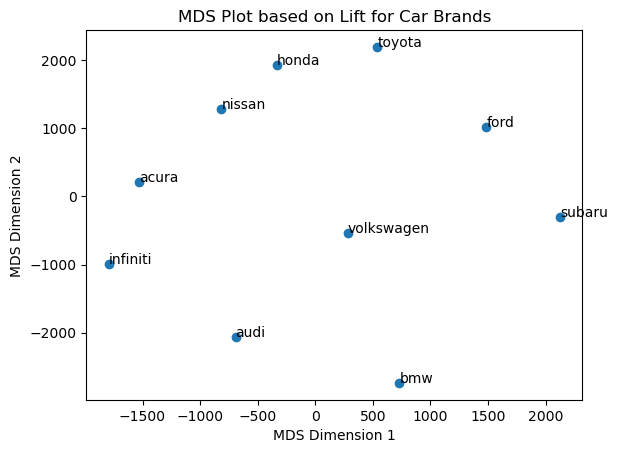

In [44]:
#Plot MDS
plt.scatter(mds_result[:, 0], mds_result[:, 1])

for i, txt in enumerate(feature_names):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

# Task C

In [45]:
import pandas as pd
from collections import Counter
import re
from collections import defaultdict
edmunds_data = pd.read_csv(r"D:\Google Drive\McGill\Winter Semester\INSY - 669\Group Assignment\Code\edmunds_extraction_5000_posts.csv")

In [46]:
# Function to clean and tokenize the post content
def clean_and_tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Tokenize by splitting on whitespace
    tokens = text.split()
    return tokens

# Function to categorize car attributes
def categorize_attribute(word):
    performance_related = ['performance', 'acceleration', 'speed', 'horsepower', 'torque', 'pickup']
    comfort_related = ['comfort', 'comfortable', 'seats', 'legroom', 'headroom']
    reliability_related = ['reliability', 'reliable', 'durability', 'dependability']
    design_related = ['design', 'style', 'looks', 'aesthetics', 'appearance']
    safety_related = ['safety', 'secure', 'protection', 'safe']
    economy_value_related = ['economy', 'value', 'cost', 'price', 'affordable', 'maintenance', 'mpg', 'fuel', 'efficient']
    driving_experience_related = ['driving', 'experience', 'handling', 'control', 'steering', 'acceleration', 'fun', 'dynamic', 'sporty']
    technology_innovation_related = ['technology', 'innovation', 'tech', 'advanced', 'modern', 'features', 'systems']
    brand_reputation_related = ['reputation', 'brand', 'prestige', 'status', 'image', 'recognition']
    eco_friendly_related = ['eco', 'environment', 'green', 'sustainable', 'emissions', 'electric', 'hybrid']

    if word in performance_related:
        return 'performance'
    elif word in comfort_related:
        return 'comfort'
    elif word in reliability_related:
        return 'reliability'
    elif word in design_related:
        return 'design'
    elif word in safety_related:
        return 'safety'
    elif word in 'economy_value_related':
        return 'economy'
    elif word in 'driving_experience_related':
        return 'experience'
    elif word in 'technology_innovation_related':
        return 'technology'
    elif word in 'brand_reputation_related':
        return 'reputation'
    elif word in 'eco_friendly_related':
        return 'eco_friendly'
    else:
        return None


In [47]:
tokenized_posts = [clean_and_tokenize(post) for post in edmunds_data.iloc[:, 2] if isinstance(post, str)]



# Flatten the list of lists into a single list of words
all_words = [word for post in tokenized_posts for word in post]

# Categorize each word and filter out non-attribute words
categorized_attributes = [categorize_attribute(word) for word in all_words]
attributes = [attr for attr in categorized_attributes if attr is not None]

# Count the frequency of each attribute
attribute_counts = Counter(attributes)

# Display the most common attributes
most_common_attributes = attribute_counts.most_common(5)
most_common_attributes

[('economy', 25263),
 ('experience', 21589),
 ('reputation', 13346),
 ('performance', 1980),
 ('design', 540)]

In [48]:
# Brands and attributes as provided by the user
most_common_brands = ['bmw', 'acura', 'honda', 'audi', 'infiniti']
attributes = {
    'economy_value_related': ['economy', 'value', 'cost', 'price', 'affordable', 'maintenance', 'mpg', 'fuel', 'efficient'],
    'driving_experience_related': ['driving', 'experience', 'handling', 'control', 'steering', 'acceleration', 'fun', 'dynamic', 'sporty'],
    'brand_reputation_related': ['reputation', 'brand', 'prestige', 'status', 'image', 'recognition'],
    'performance_related': ['performance', 'acceleration', 'speed', 'horsepower', 'torque', 'pickup'],
    'design_related': ['design', 'style', 'looks', 'aesthetics', 'appearance']
}


In [49]:
# Initialize a dictionary to hold the frequency of attributes mentioned with each brand
brand_attribute_freq = defaultdict(lambda: defaultdict(int))

In [50]:
# Function to process each post and update the brand-attribute frequency
def process_post(post):
    # Convert to lowercase for consistent matching
    post = post.lower()
    # For each brand, check if it is mentioned in the post
    for brand in most_common_brands:
        if brand in post:
            # If the brand is mentioned, increment the frequency count of each attribute if it is also mentioned
            for attribute_category, attribute_list in attributes.items():
                for attribute in attribute_list:
                    if attribute in post:
                        brand_attribute_freq[brand][attribute_category] += 1

# Apply the function to each row of the dataset
edmunds_data.applymap(lambda post: process_post(post) if isinstance(post, str) else None)

# Display the brand-attribute frequency dictionary
brand_attribute_freq

defaultdict(<function __main__.<lambda>()>,
            {'acura': defaultdict(int,
                         {'economy_value_related': 199,
                          'driving_experience_related': 317,
                          'performance_related': 232,
                          'design_related': 91,
                          'brand_reputation_related': 81}),
             'honda': defaultdict(int,
                         {'economy_value_related': 99,
                          'brand_reputation_related': 57,
                          'performance_related': 94,
                          'design_related': 42,
                          'driving_experience_related': 159}),
             'bmw': defaultdict(int,
                         {'performance_related': 578,
                          'driving_experience_related': 837,
                          'design_related': 237,
                          'economy_value_related': 604,
                          'brand_reputation_related': 187}),
    

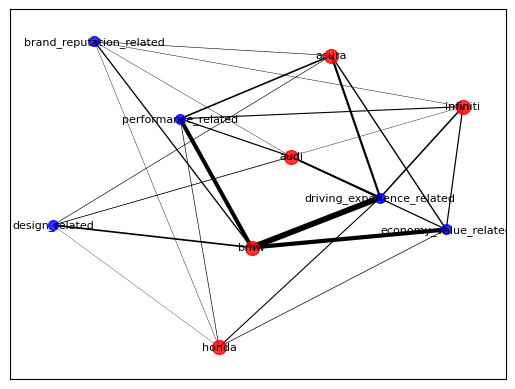

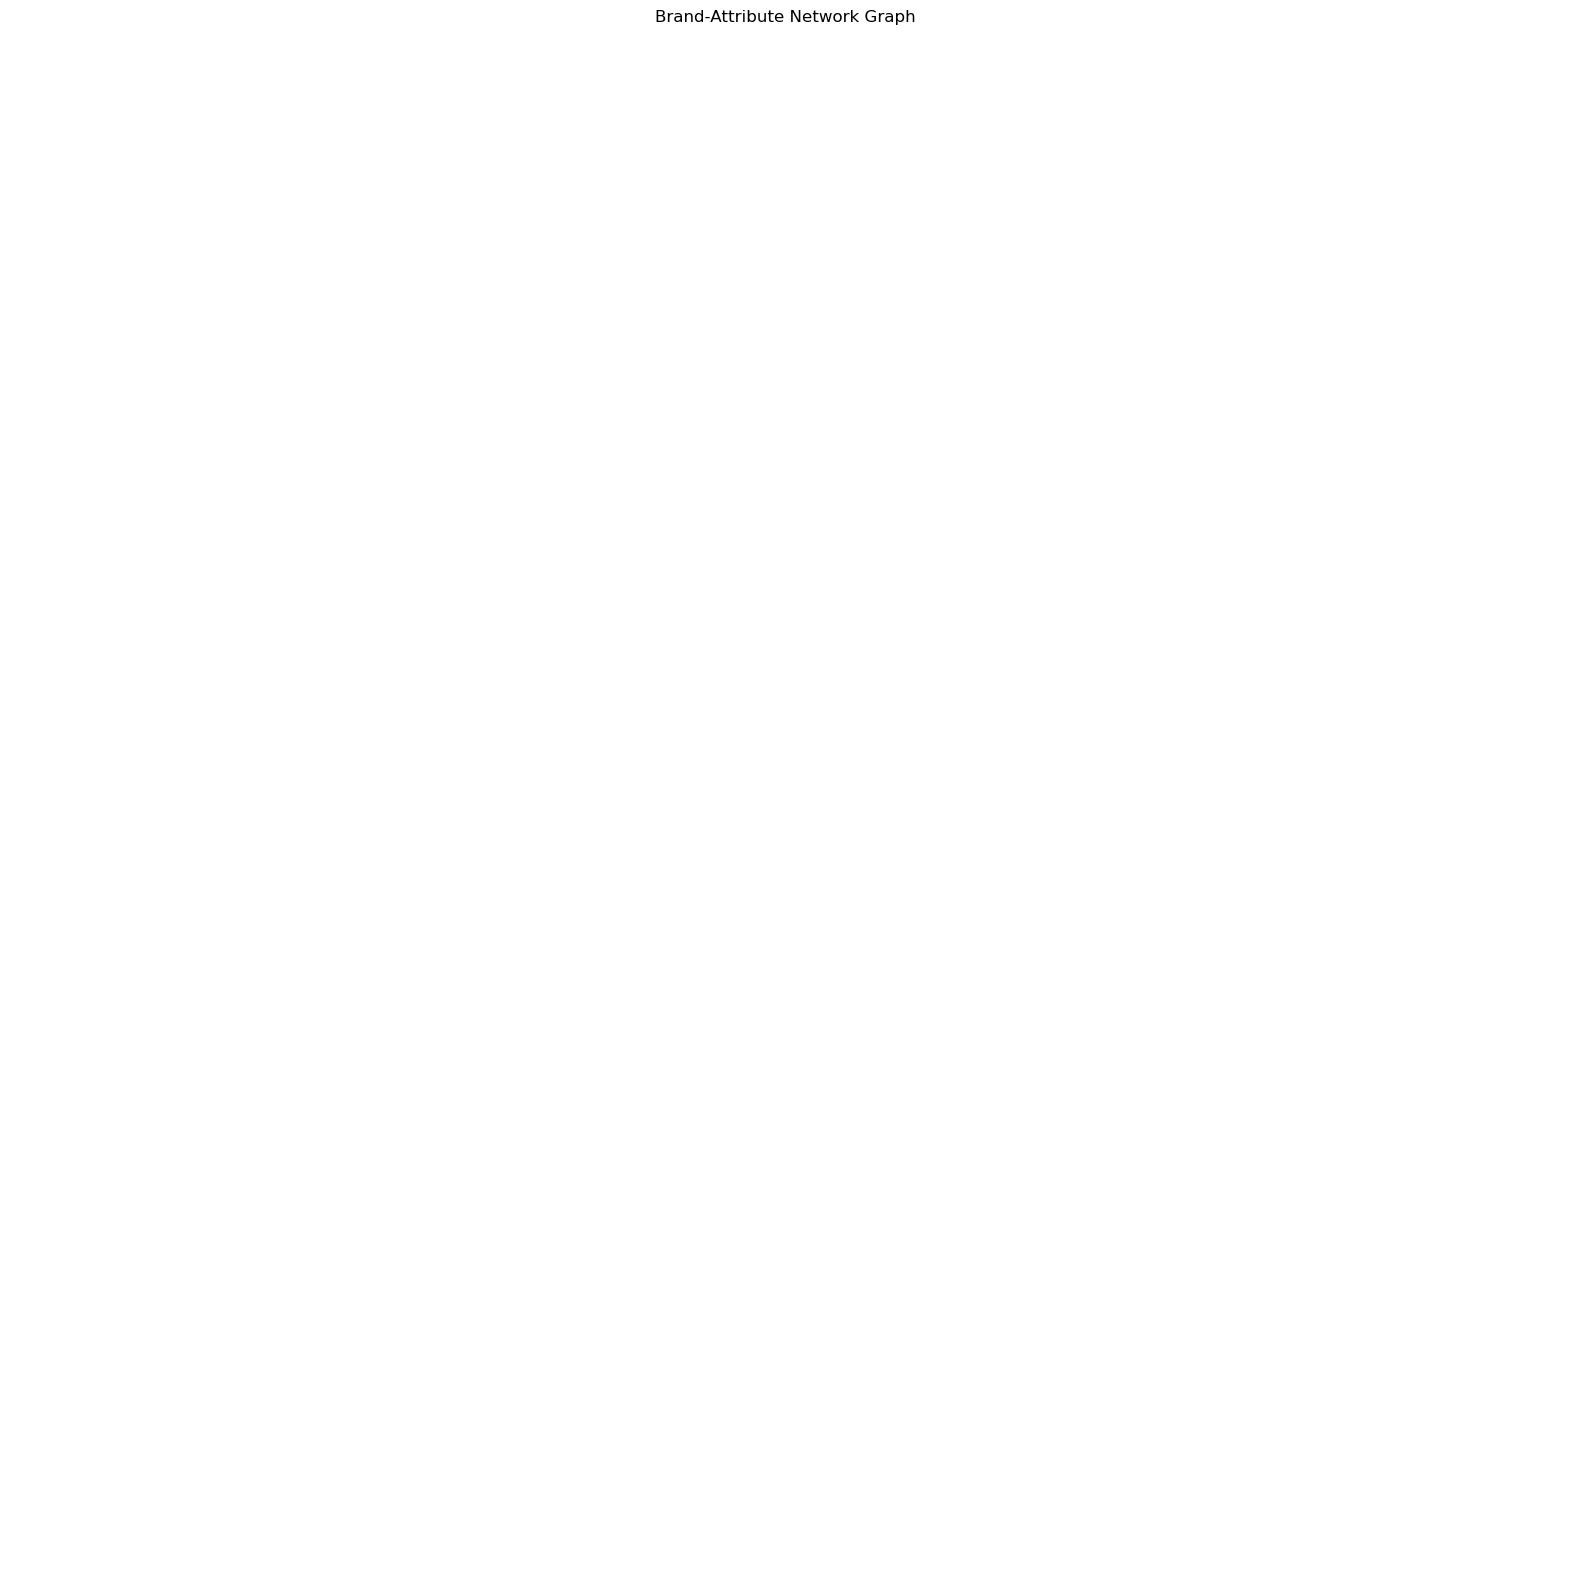

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes and edges with weights for each brand and attribute category
for brand, attributes in brand_attribute_freq.items():
    for attribute_category, weight in attributes.items():
        G.add_node(brand, type='brand', size=20)
        G.add_node(attribute_category, type='attribute_category', size=10)
        G.add_edge(brand, attribute_category, weight=weight)

# Position nodes using the spring layout
pos = nx.spring_layout(G, k=0.3, iterations=20,seed=6)

# Prepare to draw the two types of nodes differently
brand_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'brand']
attribute_category_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'attribute_category']

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, nodelist=brand_nodes, node_color='red', node_size=100, alpha=0.8)
nx.draw_networkx_nodes(G, pos, nodelist=attribute_category_nodes, node_color='blue', node_size=50, alpha=0.8)
nx.draw_networkx_labels(G, pos, labels={n: n for n in brand_nodes}, font_color='black', font_size=8)
nx.draw_networkx_labels(G, pos, labels={n: n for n in attribute_category_nodes}, font_color='black',font_size=8 )

# Draw edges with weights
edges = G.edges(data=True)
weights = [G[u][v]['weight']/200 for u,v,d in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)

# Display the graph
plt.figure(figsize=(20, 20))
plt.title("Brand-Attribute Network Graph")
plt.axis('off')
plt.show()


# Task E

In [73]:
#Read Posts data
posts=pd.read_csv('edmunds_extraction_5000_posts.csv',names=['user','date','post'])
#drop duplicates post
posts.drop_duplicates(subset='post',inplace=True)
#convert to lower case
posts['post']=posts['post'].str.lower()
posts.head()

,user,date,post
0,merc1,March 2002,i personally think that with a few tweaks the...
1,fredvh,March 2002,i am debating a new purchase and these two ar...
2,blueguydotcom,March 2002,"great handling, rwd, excellent engine and the..."
3,hungrywhale,March 2002,and no manual tranny. that may not matter to ...
4,riez,March 2002,one beauty of bmw 3 series is that there are ...


In [74]:
posts.shape

(5181, 3)

In [75]:
#model data
models=pd.read_csv('models.csv',names=['brands','model'])
#convert lower case 
models['brands']=models['brands'].str.lower()
models['model']=models['model'].str.lower()
#delete row withh  brands is cars
models.drop(models[models['brands']=='car'].index,inplace=True)
unique_brands=models['brands'].unique()


In [76]:
# models where brands is cars
models['brands'].value_counts()

toyota        98
chevrolet     63
honda         46
hyundai       40
mazda         30
suzuki        29
ford          24
bmw           22
subaru        21
nissan        17
pontiac       17
volkswagen    14
dodge         12
infiniti      10
kia           10
audi          10
acura          9
chrysler       9
lincoln        8
buick          8
mercedes       7
volvo          7
cadillac       3
mitsubishi     2
mercury        2
nissan.        2
saturn         1
toyata         1
volkwagen      1
Name: brands, dtype: int64

In [77]:
from collections import defaultdict

models_dict = defaultdict(list)

for index, row in models.iterrows():
    models_dict[row['brands']].append(row['model'])
models_dict

defaultdict(list,
            {'acura': ['integra',
              'legend',
              'vigor',
              'rlx',
              'ilx',
              'mdx',
              'rdx',
              'tsx',
              'rsx'],
             'audi': ['quattro',
              'a4',
              'a6',
              'a5',
              'a7',
              'q3',
              'q5',
              'q7',
              'a8',
              'a3'],
             'bmw': ['3-series',
              '5-series',
              '6-series',
              '4-series',
              'xdrive',
              'alpina',
              '330ci',
              '328i',
              '330c',
              '335i',
              '335d',
              '528i',
              '535i',
              '128i',
              '640i',
              '3er',
              '5er',
              'm5',
              'm3',
              'm6',
              'bmws',
              'bmwesque'],
             'buick': ['park avenue',
             

In [78]:
# Function to replace models with brands
def replace_models(text, models_dict):
    for brand, models in models_dict.items():
        for model in models:
            pattern = r'\b' + re.escape(model) + r'\b'
            text = re.sub(pattern, brand, text)
    return text

# Function to clean text
def clean_text(x):
    x = x.lower()
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r"https?://[^\s]+", "", x)
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x)
    x = ' '.join([token.lemma_ for token in nlp(x)])  
    x = re.sub(r' +', ' ', x)
    x = x.strip()
    return x

# Then apply clean_text
posts['post'] = posts['post'].apply(clean_text)


# Apply replace_models first
posts['post'] = posts['post'].apply(lambda x: replace_models(x, models_dict))

# Display the head of the DataFrame
posts.head()


,user,date,post
0,merc1,March 2002,I personally think that with a few tweak the c...
1,fredvh,March 2002,I be debate a new purchase and these two be at...
2,blueguydotcom,March 2002,"great handling , rwd , excellent engine and th..."
3,hungrywhale,March 2002,and no manual tranny . that may not matter to ...
4,riez,March 2002,one beauty of bmw 3 series be that there be so...


In [79]:
#Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
posts['sentiment_score'] = posts['post'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [84]:
posts['sentiment_score'].describe() 

count    5181.000000
mean        0.371080
std         0.523548
min        -0.996000
25%         0.000000
50%         0.493900
75%         0.837400
max         0.999400
Name: sentiment_score, dtype: float64

filtering posts with a positive compound score will remove posts with outright negative sentiments such as "not good"

In [130]:
# Filter out posts with high positive sentiment
positive_threshold = 0.6
positive_posts = posts[posts['sentiment_score'] > positive_threshold]



In [131]:
positive_posts.shape

(2272, 4)

In [132]:
# Display top positive sentiment posts  to analyze aspirational content
pd.set_option('display.max_colwidth', None)
top_positive_posts = positive_posts.nlargest(5, 'sentiment_score')['post']
print("Top Positive Sentiment Posts:")
print(top_positive_posts.to_string(index=False))

Top Positive Sentiment Posts:
I come to a different conclusion about the jaguar x - type 3.0 and the audi audi 3.0 audi . I be consider both vehicle , and it be very close , but the jaguar win for me.acceleration : in acceleration time , the jaguar be clearly fast than the audi . car&driver state of the x - type , " subjectively , the x - type do not feel quite as quick as a bmw 330i . but a few instrumented acceleration run reveal that the measure 0 - to-60 - mph time of 6.3 second be only 0.2 second slow than the small bmw . we would rate the smoothness of the x - type 's v-6 to be similarly close to that of the bavarian in - line six . "road&track say of the x - type 's performance , " in acceleration , the 3.0 x - type be among the quick . accompany by a nice - but - distant exhaust note , the jag go from 0 - 60 mph in 6.5 second , undercut the boy - racer lexus be 300 's and audi audi 's 7.1 , the mercede c320 's 6.8 sec . and match the bmw 330i 's time . "-jaguar x - type 3.0 acc

In [201]:
aspirational_keywords = [
    'wish', 'dream', 'aspire', 'hope', 'goal', 'want', 'like', 'love' 'desire',
     'faster', 'smoothness', 'quickest', 'confidence-inspiring',
     'enthusiast',
    'impressive', 'exceptional', 'extraordinary', 'fantastic', 'amazing'
    ,'incredible', 'unbelievable', 'remarkable', 'astonishing', 'phenomenal'
]


In [202]:
# Lemmatize keywords for consistency
lemmatized_keywords = set([token.lemma_ for keyword in aspirational_keywords for token in nlp(keyword)])

In [203]:
# Initialize a defaultdict for brand-keyword associations and a Counter for overall brand mentions
brand_keyword_association = defaultdict(lambda: defaultdict(int))
overall_brand_mentions = Counter()

# Process each post
for post in positive_posts['post']:
    mentioned_brands = {brand for brand in unique_brands if brand in post}
    mentioned_keywords = [keyword for keyword in aspirational_keywords if keyword in post]
    
    overall_brand_mentions.update(mentioned_brands)
    
    for brand in mentioned_brands:
        for keyword in mentioned_keywords:
            brand_keyword_association[brand][keyword] += 1

In [204]:
# Create DataFrame with brands as rows and keywords as columns
brand_keyword_matrix = pd.DataFrame.from_dict(brand_keyword_association, orient='index').fillna(0)

# Add overall brand mentions to the DataFrame
brand_keyword_matrix['Overall_Mentions'] = brand_keyword_matrix.index.map(overall_brand_mentions)

brand_keyword_matrix.index.name = 'Brand'
brand_keyword_matrix.reset_index(inplace=True)

In [205]:
brand_keyword_matrix.head()

,Brand,hope,want,like,astonishing,amazing,enthusiast,goal,wish,smoothness,impressive,incredible,exceptional,dream,fantastic,remarkable,phenomenal,aspire,faster,unbelievable,Overall_Mentions
0,chrysler,5.0,15.0,17,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46
1,buick,3.0,6.0,10,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
2,audi,18.0,79.0,145,1.0,9.0,7.0,1.0,6.0,3.0,9.0,3.0,4.0,2.0,5.0,1.0,1.0,2.0,0.0,0.0,290
3,ford,9.0,56.0,88,0.0,7.0,9.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,161
4,toyota,12.0,52.0,93,0.0,4.0,9.0,3.0,7.0,1.0,6.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,200


In [210]:
#top overall mentions
brand_keyword_matrix.nlargest(1, 'Overall_Mentions')

,Brand,hope,want,like,astonishing,amazing,enthusiast,goal,wish,smoothness,impressive,incredible,exceptional,dream,fantastic,remarkable,phenomenal,aspire,faster,unbelievable,Overall_Mentions
6,bmw,50.0,206.0,379,2.0,18.0,27.0,10.0,16.0,5.0,16.0,5.0,4.0,8.0,9.0,4.0,2.0,2.0,4.0,2.0,819


BMW mentioned most in postive sentiment posts

In [206]:
#Drop overall mentions
new_df=brand_keyword_matrix.drop('Overall_Mentions',axis=1)

In [207]:
pd.set_option('display.max_columns', None)

In [208]:
#Find the most aspirational brand with highest sum of aspirational keywords
new_df['sum'] = new_df.sum(axis=1)
most_aspirational_brand=new_df.nlargest(1,'sum')
most_aspirational_brand

,Brand,hope,want,like,astonishing,amazing,enthusiast,goal,wish,smoothness,impressive,incredible,exceptional,dream,fantastic,remarkable,phenomenal,aspire,faster,unbelievable,sum
6,bmw,50.0,206.0,379,2.0,18.0,27.0,10.0,16.0,5.0,16.0,5.0,4.0,8.0,9.0,4.0,2.0,2.0,4.0,2.0,769.0


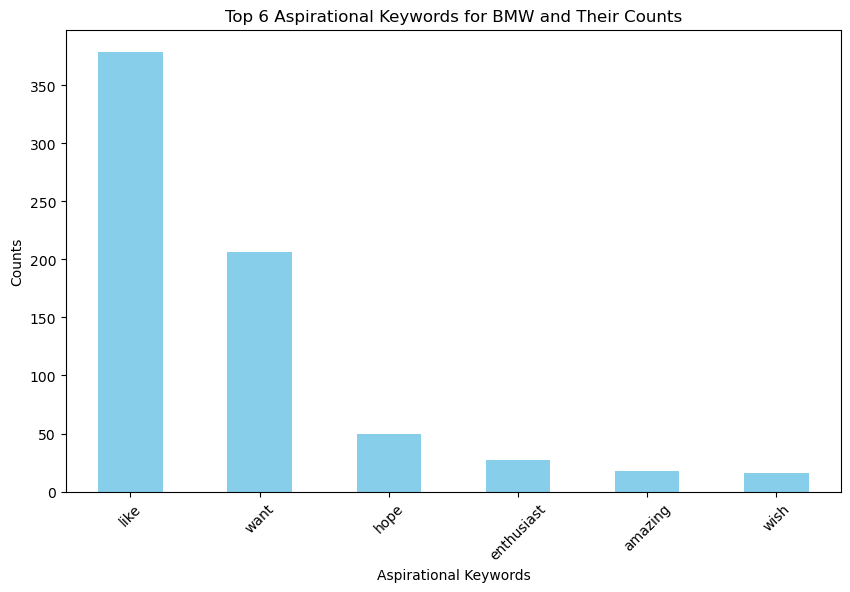

In [209]:
bmw_data = new_df.loc[new_df['Brand'] == 'bmw']

# Drop the 'Brand' and 'sum' columns as they are not keywords
bmw_keywords = bmw_data.drop(['Brand', 'sum'], axis=1)

bmw_top_keywords = bmw_keywords.T.squeeze().sort_values(ascending=False).head(6)

plt.figure(figsize=(10, 6))
bmw_top_keywords.plot(kind='bar', color='skyblue')
plt.title('Top 6 Aspirational Keywords for BMW and Their Counts')
plt.xlabel('Aspirational Keywords')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()